# MCMC fitting of a Gaussian model to partial GC data

## 0. Check pre-requiremets

In [1]:
!cat requirements.txt

matplotlib
numpy
emcee
scipy
corner
astropy
scikit_learn


In [2]:
!pip install -r requirements.txt
from IPython.display import clear_output
clear_output()

## 1. Some initial import and plotting configuration

In [3]:
# Importing modules

import sys,os, gzip
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
for axticks in ['xtick','ytick']:
    plt.rcParams['{:}.direction'.format(axticks)] = 'in'
    plt.rcParams['{:}.minor.visible'.format(axticks)] = True

from astropy import table
from astropy.table import Table
from astropy.modeling import models, fitting

import scipy
import scipy.optimize as op


## 3. Read in data

In [4]:
# Binned Corrected for all incompletenesses
# Bayer+22 
#OMP+OMR GCCs
in_data_tbl = Table.read('F606W_OMP_R_GCLF_mag_bin.dat', format ='ascii')

x_ml = in_data_tbl['F606W_0_bin_cen'].data
y_ml = in_data_tbl['N(F606W_0)_corr'].data
y_err_ml = in_data_tbl['dN(F606W_0)_corr'].data

# Generate mag Err uncertainty.
# Function parameters from artificial star analysis 
# (Bayer+22, Fig.5, Table.?)
a = 0.13345672805512762; b = 0.8871927780875304
c = 23.996784185001683 ; d = 0.010961373185291794

x_err_ml = np.empty_like(x_ml)
for i,x in enumerate(x_ml):
    mag_err = a * np.exp(b * x - c) + d
    dmag_cbin = .25
    sig_mag = dmag_cbin #/ (2*np.sqrt(2*np.log(2.)))
    x_err_ml[i] = np.sqrt(mag_err**2 + sig_mag**2)

in_data_tbl.add_column(x_err_ml, name='errMag_bin')
print(in_data_tbl)

 F606W_0_bin_cen    N(F606W_0)_corr    dN(F606W_0)_corr       errMag_bin    
------------------ ------------------ ------------------ -------------------
23.448167575958788 2.5628410308451186 1.6008875759543888 0.25053967072505723
23.948167575958788  3.116858944867921 1.7654628132214853   0.250758705959877
24.448167575958788 11.791402551237518  3.433861172388528  0.2511737849715475
24.948167575958788 21.368922184143322  4.622653154211694 0.25199871449520006
25.448167575958788 48.238289921068805  6.945379033650274 0.25371194032315203
25.948167575958788  70.29118329475541  8.383983736551224  0.2573966738608378


## 4. Visualize the data

Text(0, 0.5, 'N$_{\\rm GCCs}$')

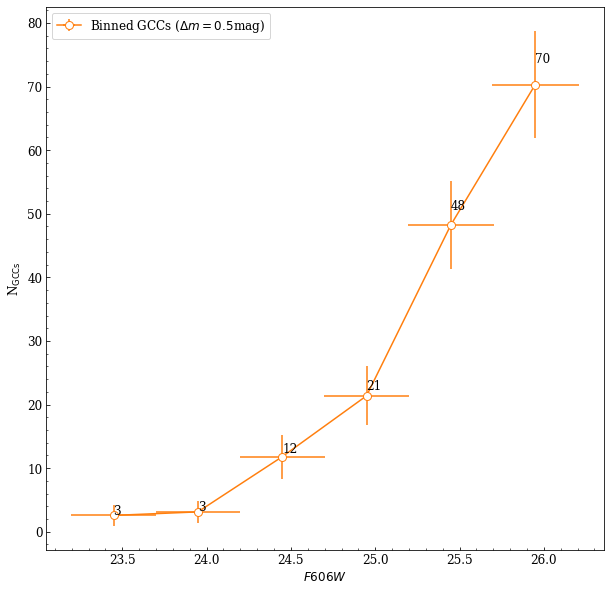

In [5]:
# Visualize it

fig,ax = plt.subplots(figsize=(10,10))

ax.errorbar(x_ml, y_ml, xerr=x_err_ml, #/sigmoid(x_ml,amplitude=1, x50=m50_606, k=-k_606),
            yerr=y_err_ml, color='C1',
            marker='o', mfc='white', ms=8, label=r'Binned GCCs ($\Delta m=0.5$mag)',
           )
for i,n in enumerate(y_ml): #/sigmoid(x_ml,amplitude=1, x50=m50_606, k=-k_606)):
    ax.text(x_ml[i],n*1.05, '{:}'.format(round(n)))

try:
    ax.axvline(m80_606, ls=':', label=r'm80$_{F606W}$')
except:
    pass

ax.legend(loc='upper left')

ax.set_xlabel(r'$F606W$')
ax.set_ylabel(r'N$_{\rm GCCs}$')

## 4. First, a maximum likelihood fitting 
To get an initial guess for the values of the model parameters for the MCMC initialisation

### Define the model

In [6]:
def myGaussian(x, amplitude, sigma, mu):
    A = 1./(sigma * (2*np.pi)**0.5)
    y = amplitude * A * np.exp(-0.5 * (x - mu)**2. / sigma**2.)
    return y

### Define the likelihood function

In [7]:
def lnlike(theta, x, y, yerr, xerr):
    
    amplitude, sigma, mu, lnf = theta 
    
    model = myGaussian(x, amplitude, sigma, mu)
    model_dx = model * ( (x - mu)/sigma**2 ) # Private derivative over x 
    msig_xerr = model_dx * xerr
    
    inv_sigma2 = 1.0/(msig_xerr**2 + yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 -
                        np.log(2*np.pi*inv_sigma2))
                )

### ML fit

In [8]:
# Some initial guesses for our parameters

import scipy
import scipy.optimize as op

# GCLF initial guesses
amplitude_init, mu_init, sigma_init, myGauss_init = 500, 27.63, 1.3, 0.01

p2 = [amplitude_init, sigma_init, mu_init, myGauss_init]

# ML Fit
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll,
                     p2,
                     args=(x_ml, y_ml, y_err_ml, x_err_ml)
                    )
if not(result['success']):
    print("Max likelihood failed.")
    print(result['message'])

amplitude_ml, sigma_ml, mu_ml, myGauss_ml = result['x'] #mu_ml, sigma_ml, 
print('amplitude={:.2f}, sig={:.2f}, mu={:.2f}, lnlikef={:.2f}'.format(amplitude_ml, sigma_ml, mu_ml, myGauss_ml)
     )


amplitude=292.87, sig=1.24, mu=27.03, lnlikef=-22967.45


### Visualize tha data, initial guess and ML best fit

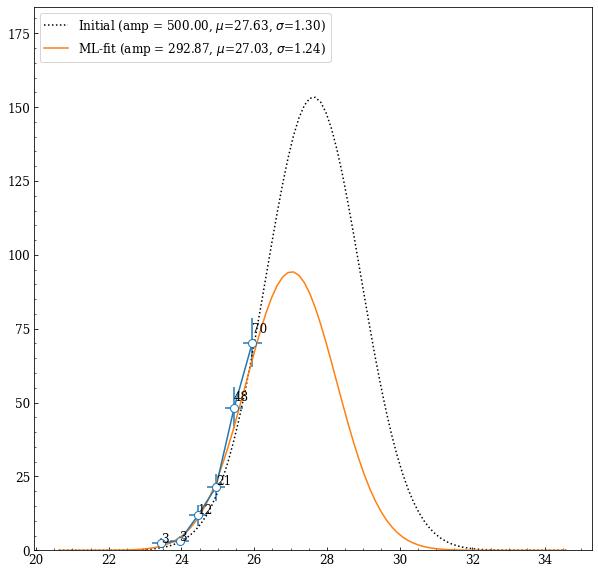

In [9]:
# Plot
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

ax.errorbar(x_ml, y_ml, yerr=y_err_ml, xerr=x_err_ml,
                marker='o', mfc='white', ms=8,
               )
for i,n in enumerate(y_ml):
    ax.text(x_ml[i],y_ml[i]*1.05, '{:}'.format(round(n)))

x_samples = np.arange(mu_init-7,mu_init+7,.15)
ax.plot(x_samples,
        #myGaussian(x_samples, amplitude_init, sigma=sigma_init), ':', color='black',
        myGaussian(x_samples, amplitude_init, sigma=sigma_init, mu=mu_init), ':', color='black',
        label = r'Initial (amp = {:.2f}, $\mu$={:.2f}, $\sigma$={:.2f})'.format(amplitude_init, mu_init, sigma_init)
       )
ax.plot(x_samples,
        #myGaussian(x_samples, amplitude_ml, sigma_ml), '-',
        myGaussian(x_samples, amplitude_ml, sigma_ml, mu_ml), '-',
        label = 'ML-fit (amp = {:.2f}, $\mu$={:.2f}, $\sigma$={:.2f})'.format(amplitude_ml, mu_ml, sigma_ml)
       )

ax.set_ylim(0,1.2*np.max(myGaussian(x_samples, amplitude_init, sigma=sigma_init, mu=mu_init)))

ax.legend(loc='upper left')

In [10]:
filename = 'GCLF.pdf'
fig.savefig(filename, format='pdf', transparent=True, bbox_inches='tight', dpi=100)
#os.system('pdfcrop {:} {:} ; open {:}'.format(filename, filename, filename))
os.system('pdfcrop {:} {:}'.format(filename, filename))

32512

## 5. MCMC 

### Define the priors and the loglikelihood

In [11]:
#Define the priors for the model parameters

def lnprior(theta):

    # myGaussian
    amplitude, sigma, mu, lnf = theta

    # Flat prior on amplitude and sigma
    if (100. <= amplitude <= 1750 and 0.75 <= sigma <= 2.05 and -10 < lnf < 1.0):
        mu_sig = 0.25
        lnprior_val = -np.log(1.0/(np.sqrt(2*np.pi)*mu_sig)) - 0.5*(mu-mu_init)**2/mu_sig**2
        return lnprior_val

    return -np.inf

In [12]:
# Log likelihood probability function
def lnprob(theta, x, y, yerr, xerr):
    
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    try:
        lnprobval = lp
        if not np.any(np.isnan(lnlike(theta, x, y, yerr, xerr))):
            lnprobval += lnlike(theta, x, y, yerr, xerr)
    except:
        lnprobval = -np.inf
        
    return lnprobval


### Prepare and run the MCMC

In [13]:
# Define the MCMC chains
ndim = 4
nwalkers = 200
steps = 10000
nthreads = 4

In [14]:
# initialize the walkers to the vicinity of the parameters derived from
# ML (ideally)

pos = [np.array([amplitude_init, sigma_init, mu_init, myGauss_init]) + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [15]:
import time 
import emcee
from multiprocessing import Pool

with Pool() as pool:
    # Initialize the sampler
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool,
                                    args=(x_ml, y_ml, y_err_ml, x_err_ml))
    # Run!
    start = time.time()
    sampler.run_mcmc(pos, steps, progress=True)
    end = time.time()
    run_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(run_time))
    #print("{0:.1f} times faster than serial".format(serial_time / multi_time))


100%|██████████| 10000/10000 [04:05<00:00, 40.81it/s]

Multiprocessing took 245.2 seconds


In [16]:
#What is the acceptance rate? Lore has it that this should be between $0.3-0.5$.

print("Mean acceptance rate is: {0:1.2f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance rate is: 0.54


In [17]:
# Save the sampler as a pickle
import gzip, pickle

filename = 'GCLF_mcmc_sampler_pickle.gz'

with gzip.open(filename, 'wb') as f:
    pickle.dump(sampler, f, pickle.HIGHEST_PROTOCOL)


In [18]:
# (OPTIONAL) Load the model\n",
import pickle

filename = 'GCLF_mcmc_sampler_pickle.gz'

with gzip.open(filename, 'rb') as f:
    print('Decompressing the pickle file ... {:s}'.format(filename))
    sampler = pickle.load(f)
    

Decompressing the pickle file ... GCLF_mcmc_sampler_pickle.gz


In [19]:
samples = sampler.chain

### Plot the MCMC chains

Text(0.5, 0, 'step')

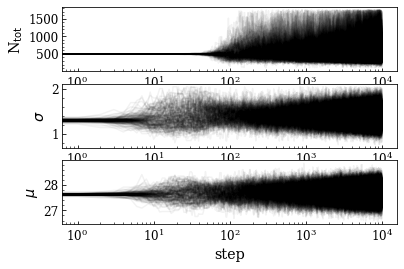

In [20]:
#This acceptance rate is okay. If it is too low, the emcee documentation 
#suggests increasing the number of walkers until the acceptance fraction is at 
#the desired level.
#
#Let's visualize the chains.

fig = plt.figure()
dim_name = [r'N$_{\rm tot}$', '$\sigma$', r'$\mu$', r'$\ln f$']

#ndim-1 is to not show the lnf
for dim in range(ndim-1):
    ax = fig.add_subplot(ndim-1, 1, dim+1)
    for i in range(nwalkers):
        ax.plot(np.arange(steps),
                samples[i, :, dim],
                ls='-',
                color='black',
                alpha=10./nwalkers,
                rasterized=True
               )
    ax.set_ylabel(dim_name[dim], fontsize='large')
#    ax.set_ylim(np.percentile(samples[i, :, dim],[1,99]))
    ax.set_xscale('log')
ax.set_xlabel('step', fontsize='large')



In [21]:
filename = 'GCLF_mcmc_steps.pdf'

fig.savefig('{:}'.format(filename), format='pdf', transparent=True,
            bbox_inches='tight', dpi=100
           )
os.system('pdfcrop {:} {:}'.format(filename,filename))

32512

In [22]:
import gc,time
start = time.time()
gc.collect()
print('Cleaning duration {:.1f} seconds'.format(time.time()-start))

Cleaning duration 0.1 seconds


### Make the corner plot

In [23]:
#It looks like the walkers have "burned in" by 100 steps, 
#so keep only those samples after 100 steps.

#samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
samples = sampler.chain[:, 100:, :ndim-1].reshape((-1, ndim-1)) # Use this if you want to avoid showing the lnf


In [24]:
# Limit by patrameter value
sample_limits_bl = False

Ntot_low = samples[:,0].min() ; Ntot_upp = samples[:,0].max()
sig_low = samples[:,1].min() ; sig_upp = samples[:,1].max()
mu_low = samples[:,2].min() ; mu_upp = samples[:,2].max()
#lnf_low = samples[:,3].min() ; lnf_upp = -2e3 #samples[:,3].max()

sample_lims = (samples[:,0]>Ntot_low) & (samples[:,0]<Ntot_upp) & \
                (samples[:,1]>sig_low) & (samples[:,1]<sig_upp) & \
                (samples[:,2]>mu_low) & (samples[:,2]<mu_upp) #& \
#                (samples[:,3]>lnf_low) & (samples[:,3]<lnf_upp)


if sample_limits_bl:
    samples = samples[:,:][ sample_lims ]

In [25]:
# Show kde over the corner histograms?
show_kde = False

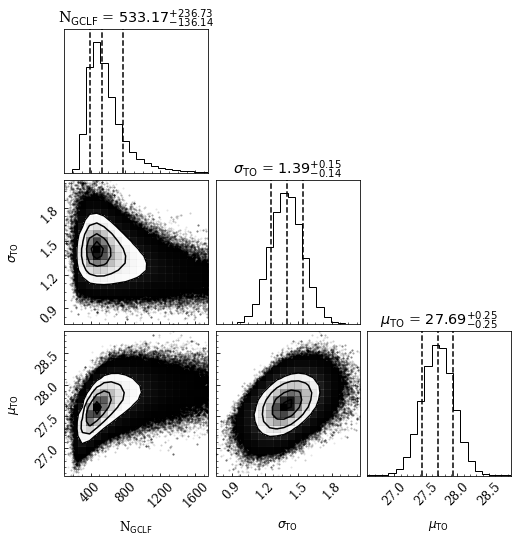

In [26]:
import corner
from sklearn.neighbors import KernelDensity

fig = corner.corner(samples,
                    #labels=['xmax', 'x50', 'k', r'$\ln f$'],
                    labels=[r'N$_{\rm GCLF}$', r'$\sigma_{\rm TO}$', r'$\mu_{\rm TO}$'], #r'$\ln f$'], #'mu'], #
                    quantiles=[0.16, 0.5, 0.84], rasterized=True,
                    #truths=[b_true,
                    #        m_true,
                    #        np.log(f_true)],
                    show_titles=True)

if show_kde:
    if samples.shape[1] == ndim: # If the lnf is not removed from the samples
        samples[:, ndim-1] = np.exp(samples[:, ndim-1])

    # Extract the axes
    axes = np.array(fig.axes).reshape((ndim-1, ndim-1))
    labels=[r'N$_{tot}$', r'$\sigma$', r'$\mu$']

    for alabel,dim in zip(labels,range(ndim-1)):
        dim_samples = samples[:, dim]
        kde_bin = (np.nanmax(dim_samples)-np.nanmin(dim_samples))/30.

        X = dim_samples[:,None]

        print('KDE estimation with kde bin = {:.3f}'.format(kde_bin))
        kde = KernelDensity(kernel='gaussian', bandwidth=kde_bin).fit(X)

        print('KDE scores')
        samples_kde = np.linspace(X.min(),X.max(),100)
        log_dens_kde = kde.score_samples(samples_kde[:,None])

        samp_d = (X.max()-X.min())/100

        kde_xy = np.array([samples_kde, np.exp(log_dens_kde) * len(X) * samp_d * (100/30)])

        print('KDE peak = ', end ='')
        kde_y_max = np.nanmax(kde_xy[1])
        kde_peak = kde_xy[0][kde_xy[1] == kde_xy[1].max()][0]
        fwhm_low = 2*kde_peak/(kde_peak*.93)
        fwhm_upp = 2*kde_peak/(kde_peak*1.07)
        fwhm_peak_kde = kde_xy[0][(kde_xy[1] > kde_y_max/fwhm_low) & (kde_xy[1] < kde_y_max/fwhm_upp)]
        hwhm_peak_kde_low = kde_peak-fwhm_peak_kde.min()
        hwhm_peak_kde_upp = fwhm_peak_kde.max()-kde_peak
        print('{:.3f} +{:.3f}, -{:.3f}'.format(kde_peak,hwhm_peak_kde_upp,hwhm_peak_kde_low))
        dim_par_lab = r'{:} = {:.3f} $^{{+{:.3f}}}_{{-{:.3f}}}$'.format(alabel,kde_peak,hwhm_peak_kde_upp,abs(hwhm_peak_kde_low))

        # Loop over the diagonal
        ax = axes[dim, dim]
        ax.axvline(kde_peak, color='C0')
        ax.axvline(kde_peak-abs(hwhm_peak_kde_low), color='C0')
        ax.axvline(hwhm_peak_kde_upp+kde_peak, color='C0')
        ax.plot(kde_xy[0], kde_xy[1], '-', color='C0')
        ax.text(ax.get_xlim()[0],
                ax.get_ylim()[1]*1.22, '{:s}'.format(dim_par_lab), color='C0')

In [27]:
filename = 'GCLF_mcmc_corner.pdf'

fig.savefig('{:}'.format(filename), format='pdf', transparent=True,
            bbox_inches='tight', dpi=100
           )
try:
    os.system('pdfcrop {:} {:}'.format(filename,filename))
    os.system('open {:}'.format(filename))
except:
    print('Skipping white space removal in the pdf: pdfcrop not installed.')

In [28]:
# Print the MCMC parameters

#samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
#samples[:, ndim-1] = np.exp(samples[:, ndim-1])
#amplitude_mcmc, sigma_mcmc, mu_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                                       zip(*np.percentile(samples, [16, 50, 84],
#                                                          axis=0)))
amplitude_mcmc, sigma_mcmc, mu_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                       zip(*np.percentile(samples, [16, 50, 84],
                                                          axis=0)))

print("MCMC Parameter estimates:")
print("amplitude:\t{:.2f}\t(+{:.2f}, -{:.2f}) [N]".format(amplitude_mcmc[0],
                                                        amplitude_mcmc[1],
                                                        amplitude_mcmc[2]))
print("mu:\t{:.2f}\t(+{:.2f}, -{:.2f}) [mag]".format(mu_mcmc[0],
                                              mu_mcmc[1],
                                              mu_mcmc[2]))
print("sigma:\t{:.2f}\t(+{:.2f}, -{:.2f}) [mag]".format(sigma_mcmc[0],
                                              sigma_mcmc[1],
                                              sigma_mcmc[2]))


MCMC Parameter estimates:
amplitude:	533.17	(+236.73, -136.14) [N]
mu:	27.69	(+0.25, -0.25) [mag]
sigma:	1.39	(+0.15, -0.14) [mag]


### Visualize the MCMC results

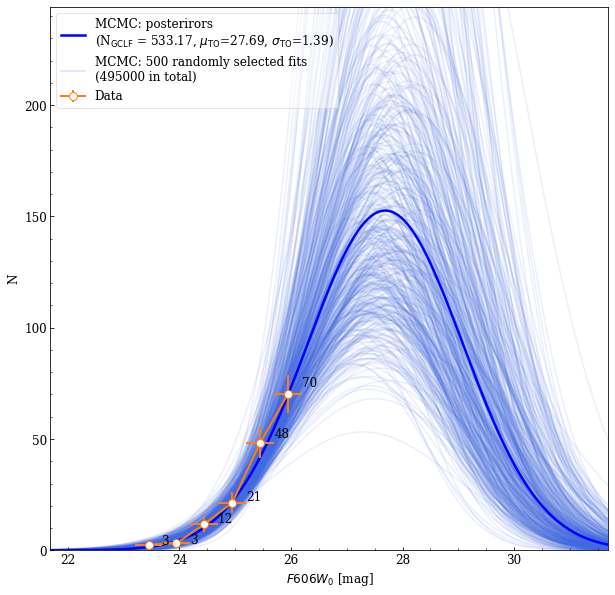

In [29]:
# Visualize the results
lb_show_init = False # Show the Initial expextation and ML fit?
n_fits = 500
plt_samples = samples #sampler.chain[:, :25, :].reshape((-1, ndim))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.errorbar(x_ml, y_ml, xerr=x_err_ml, yerr=y_err_ml, lw=2, zorder=n_fits,
                marker='o', mfc='white', color='C1', ms=8, label='Data'
               )
for i,n in enumerate(y_ml):
    ax.text(x_ml[i]*1.01,y_ml[i]*1.05, '{:}'.format(round(n)), zorder=n_fits+1)

x_samples = np.arange(mu_init-7,mu_init+7,.05)
if lb_show_init:
    ax.plot(x_samples,
            myGaussian(x_samples, amplitude_init, sigma=sigma_init, mu=mu_init),
            ':', color='black', lw=3, zorder=n_fits-3,
            label=r'Initial expectation (N$_{{\rm GCLF}}$ = {:.2f}, $\mu_{\rm TO}$={:.2f}, $\sigma_{\rm TO}$={:.2f})'.format(amplitude_init, mu_init, sigma_init)
           )
    ax.plot(x_samples,
            myGaussian(x_samples, amplitude_ml, sigma=sigma_ml, mu=mu_ml), '--', color='cyan', lw=3, zorder=n_fits-2,
            label=r'Max.-L. fit (amp = {:.2f}, $\mu_{\rm TO}$={:.2f}, $\sigma_{\rm TO}$={:.2f})'.format(amplitude_ml, mu_ml, sigma_ml)
           )
ax.plot(x_samples,
        myGaussian(x_samples, amplitude_mcmc[0], sigma=sigma_mcmc[0], mu=mu_mcmc[0]),
        color='blue', lw=2.5, zorder=n_fits-1, alpha=1,
        label='MCMC: posterirors\n'+r'(N$_{{\rm GCLF}}$ = {:.2f}, $\mu_{{\rm TO}}$={:.2f}, $\sigma_{{\rm TO}}$={:.2f})'.format(amplitude_mcmc[0], mu_mcmc[0], sigma_mcmc[0])
       )

#for i,(tamp, tsigma, tmu, _) in enumerate(plt_samples[np.random.randint(len(plt_samples), size=n_fits)]):
for i,(tamp, tsigma, tmu) in enumerate(plt_samples[np.random.randint(len(plt_samples), size=n_fits)]):
    if i==0:
        ax.plot(x_samples,
                myGaussian(x_samples, tamp, sigma=tsigma, mu=tmu), color='royalblue',
                alpha=0.2, zorder=0,
                label='MCMC: {:} randomly selected fits\n({:.0f} in total)'.format(n_fits,len(samples)/ndim)
               )
    else:
        ax.plot(x_samples,
                myGaussian(x_samples, tamp, sigma=tsigma, mu=tmu),
                color='royalblue', alpha=0.1, rasterized=True, zorder=0)

ax.set_xlim(mu_mcmc[0]-6,mu_mcmc[0]+4)
ax.set_ylim(0,1.6*np.max(myGaussian(x_samples, amplitude=amplitude_mcmc[0], sigma=sigma_mcmc[0], mu=mu_mcmc[0])))
ax.set_xlabel(r'$F606W_0$ [mag]')
ax.set_ylabel('N')
ax.legend(loc='upper left', framealpha=0.5)


In [30]:
filename = 'GCLF_mcmc.pdf'

fig.savefig(filename, format='pdf', transparent=True, bbox_inches='tight', dpi=100
           )
try:
    os.system('pdfcrop {:} {:}'.format(filename,filename))
    os.system('open {:}'.format(filename))
except Exception as e:
    print(e)

In [31]:
import gc
start = time.time()
gc.collect()
print('Cleaning duration {:.1f} seconds'.format(time.time()-start))

Cleaning duration 0.2 seconds
